In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Retrieve Data

In [12]:
hp_df = pd.read_csv("data/2019.csv")
hp = hp_df[hp_df.columns[[1,2,3]]]

gdp_df = pd.read_csv("data/gdp19.csv",skiprows=4)
gdp = gdp_df[['Country Name', '2019']]

data = hp.merge(gdp, left_on='Country or region', right_on='Country Name').drop('Country Name', axis=1).dropna()
print(data.head())

  Country or region  Score  GDP per capita          2019
0           Finland  7.769           1.340  48685.853987
1           Denmark  7.600           1.383  59822.092961
2            Norway  7.554           1.488  75419.634869
3           Iceland  7.494           1.380  66944.825508
4       Netherlands  7.488           1.396  52447.831439


# Scatter Plots of Data

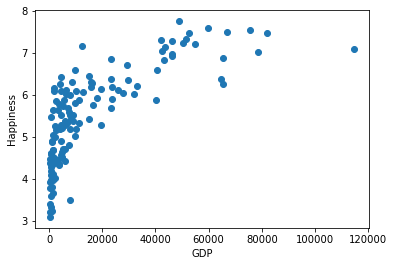

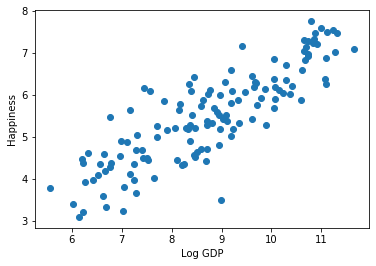

In [13]:
plt.scatter((data[['2019']]),data[['Score']])
plt.xlabel('GDP')
plt.ylabel('Happiness')
plt.show()

plt.scatter(np.log(data[['2019']]),data[['Score']])
plt.xlabel('Log GDP')
plt.ylabel('Happiness')

#Since LOG GDP has linear relationship, we choose to regress on that instead.
data[['2019']] = np.log(data[['2019']])

Log_GDP = data['2019'].tolist()
Happiness = data['Score'].tolist()

In [4]:
#Code based off Gaussian and MonteCarlo Problem:
def CreateObservationOperator(gdp):
    N = len(gdp)
    A = np.ones((N, 2))
    for i in range(N):
        A[i][1] = gdp[i]
    return A
def GetPrior():
    return np.array([0, 1]), np.array([[5, 0.0], [0.0, 1]])
def ComputeCovariances(A, sigma_xx, sigma_eps):
    N = np.shape(A)[0]
    sigma_zz = A @ sigma_xx @ A.T + sigma_eps ** 2 * np.eye(N)
    sigma_zx = A@sigma_xx
    return sigma_zz, sigma_zx
def ComputePosterior(obs_val, mu_x, mu_y, sigma_xx, sigma_yy, sigma_yx):
    dim_x = mu_x.shape[0]
    dim_y = mu_y.shape[0]
    
    assert((dim_x==sigma_xx.shape[0])&(dim_x==sigma_xx.shape[1]))
    assert((dim_y==sigma_yy.shape[0])&(dim_y==sigma_yy.shape[1]))
    assert((dim_y==sigma_yx.shape[0])&(dim_x==sigma_yx.shape[1]))
    
    K = np.linalg.solve(sigma_yy, sigma_yx).T
    
    post_mu = mu_x + K@(obs_val - mu_y)
    
    post_cov = sigma_xx - sigma_yx.T@np.linalg.inv(sigma_yy) @ sigma_yx
    return post_mu, post_cov

# Set Up Model

In [5]:
obs_var = 1.0
A = CreateObservationOperator(Log_GDP)

# Set Up Joint Prior

In [6]:
mu_x, sigma_xx = GetPrior()
mu_z = A@mu_x
sigma_zz, sigma_zx =  ComputeCovariances(A, sigma_xx, obs_var)

# Get Posterior Mean and Covariance

In [7]:
post_mu, post_cov = ComputePosterior(Happiness, mu_x, mu_z, sigma_xx, sigma_zz, sigma_zx)
print(post_mu, post_cov)

[-0.09661236  0.63996268] [[ 0.25337614 -0.02814192]
 [-0.02814192  0.00322185]]


# Graph Regression

In [8]:
pred_times = np.linspace(5, 12,1000)
pred_A= CreateObservationOperator(pred_times)

pred_mean = pred_A@post_mu
pred_cov = pred_A@post_cov@pred_A.T + obs_var*np.eye(pred_times.shape[0])

# Extract the standard deviation of the predictions, which is the square root of the diagonal of the prediction covariance
pred_std = np.sqrt(np.diag(pred_cov))

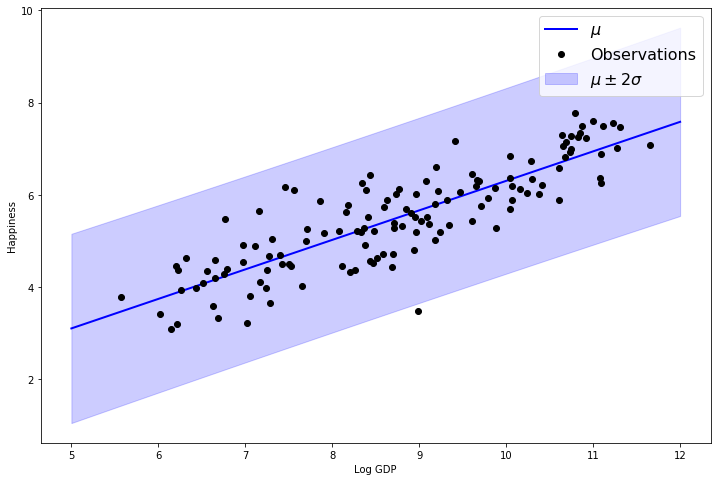

In [9]:
plt.figure(figsize=(12,8))

plt.fill_between(pred_times, pred_mean+2*pred_std, pred_mean-2*pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
plt.plot(pred_times, pred_mean, 'b', linewidth=2, label='$\mu$')
plt.plot(Log_GDP, Happiness, 'ok', label='Observations')

plt.legend(fontsize=16)
plt.xlabel('Log GDP')
plt.ylabel('Happiness')
plt.show()

# GDP VS Happiness

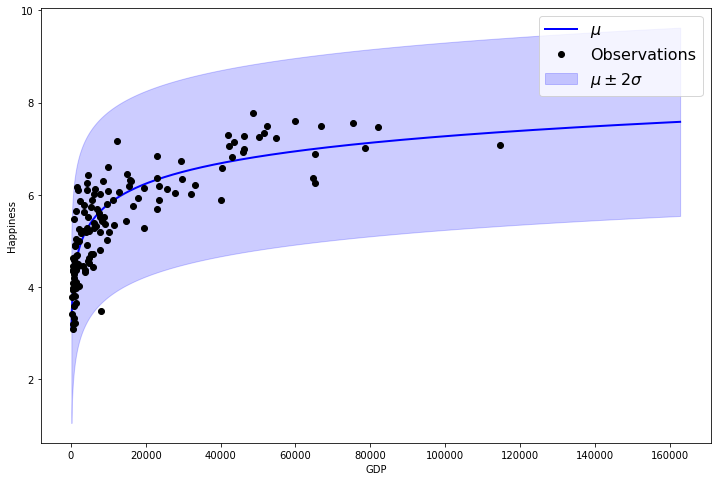

In [10]:
plt.figure(figsize=(12,8))

plt.fill_between(np.exp(pred_times), pred_mean+2*pred_std, pred_mean-2*pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
plt.plot(np.exp(pred_times), pred_mean, 'b', linewidth=2, label='$\mu$')
plt.plot(np.exp(Log_GDP), Happiness, 'ok', label='Observations')

plt.legend(fontsize=16)
plt.xlabel('GDP')
plt.ylabel('Happiness')

plt.show()

# Log GDP vs GDP Score

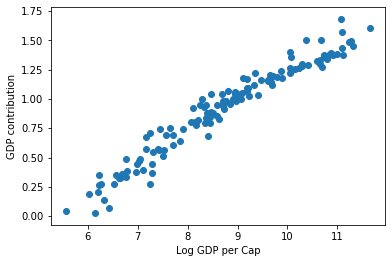

In [11]:
# plt.plot(Log_GDP,hp_df['GDP per capita'].tolist())
plt.scatter(data['2019'].tolist(), data['GDP per capita'].tolist())
plt.xlabel('Log GDP per Cap')
plt.ylabel('GDP contribution')
plt.show()